In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import random
import torchvision.transforms.functional as TF

In [ ]:
DATA_DIR = "train"
TRAIN_CSV = "train.csv"

def get_residual(img_tensor):
    """
    Calculates the residual (Noise) stream feature: Image - GaussianBlur(Image)
    Logic from Stream B in ThreeStreamModel
    """
    # Ensure tensor is (C, H, W)
    blurred = TF.gaussian_blur(img_tensor, kernel_size=3, sigma=1.0)
    return img_tensor - blurred

def get_spectrum(img_tensor):
    """
    Calculates the frequency stream feature: FFT Log-Spectrum
    Logic from Stream C in ThreeStreamModel
    """
    # Convert to grayscale: (1, H, W)
    gray = TF.rgb_to_grayscale(img_tensor)
    # Compute FFT
    fft = torch.fft.fft2(gray)
    # Shift zero frequency to center
    fft_shift = torch.fft.fftshift(fft)
    # Compute magnitude and log scale
    magnitude = 20 * torch.log(torch.abs(fft_shift) + 1e-8)
    return magnitude

def visualize_streams(data_dir, csv_path, num_samples=5, target_label=None):

    df = pd.read_csv(csv_path)
    
    # Create a mapping from filename (basename) to label
    label_map = {os.path.basename(path): label for path, label in zip(df['file_name'], df['label'])}
    
    image_dir = data_dir

    # List actual files in the directory
    all_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    
    # Filter by target_label if provided
    if target_label is not None:
        all_files = [f for f in all_files if label_map.get(f) == target_label]
        print(f"Found {len(all_files)} images with label {target_label}")

    if not all_files:
        print("No images found.")
        return
    
    selected_files = random.sample(all_files, min(num_samples, len(all_files)))
    
    for i, file_name in enumerate(selected_files):
        img_path = os.path.join(image_dir, file_name)
        
        # Look up label using basename
        label = label_map.get(file_name, 'Unknown')
        
        try:
            # Load and Preprocess
            img = Image.open(img_path).convert('RGB')
            img_tensor = TF.to_tensor(img) # Converts to [0, 1]
            
            # Create a new figure for each image
            plt.figure(figsize=(18, 6))
            
            # 1. Original Image
            plt.subplot(1, 3, 1)
            plt.imshow(img)
            plt.title(f"Original (Label: {label})\n{file_name}")
            plt.axis('off')
            
            # 2. Stream B: Residual (Noise)
            residual = get_residual(img_tensor)
            # Normalize for visualization: shift min-max to 0-1
            res_np = residual.permute(1, 2, 0).numpy()
            res_vis = (res_np - res_np.min()) / (res_np.max() - res_np.min() + 1e-8)
            
            plt.subplot(1, 3, 2)
            plt.imshow(res_vis)
            plt.title("Stream B: Residual / Noise\n(High Frequency Details)")
            plt.axis('off')
            
            # 3. Stream C: Frequency (Spectrum)
            spectrum = get_spectrum(img_tensor)
            spec_np = spectrum.squeeze(0).numpy()
            
            plt.subplot(1, 3, 3)
            plt.imshow(spec_np, cmap='inferno')
            plt.title("Stream C: Frequency Spectrum\n(FFT Magnitude)")
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Could not load {img_path}: {e}")

# Run visualization
print("Visualizing AI Generated Images (Label 1):")
visualize_streams(DATA_DIR, TRAIN_CSV, num_samples=10, target_label=1)

In [ ]:
print("Visualizing Real Images (Label 0):")
visualize_streams(DATA_DIR, TRAIN_CSV, num_samples=20, target_label=0)

Visualizing YCbCr for AI Generated Images (Label 1):
Found 121 images with label 1
Found 121 images with label 1


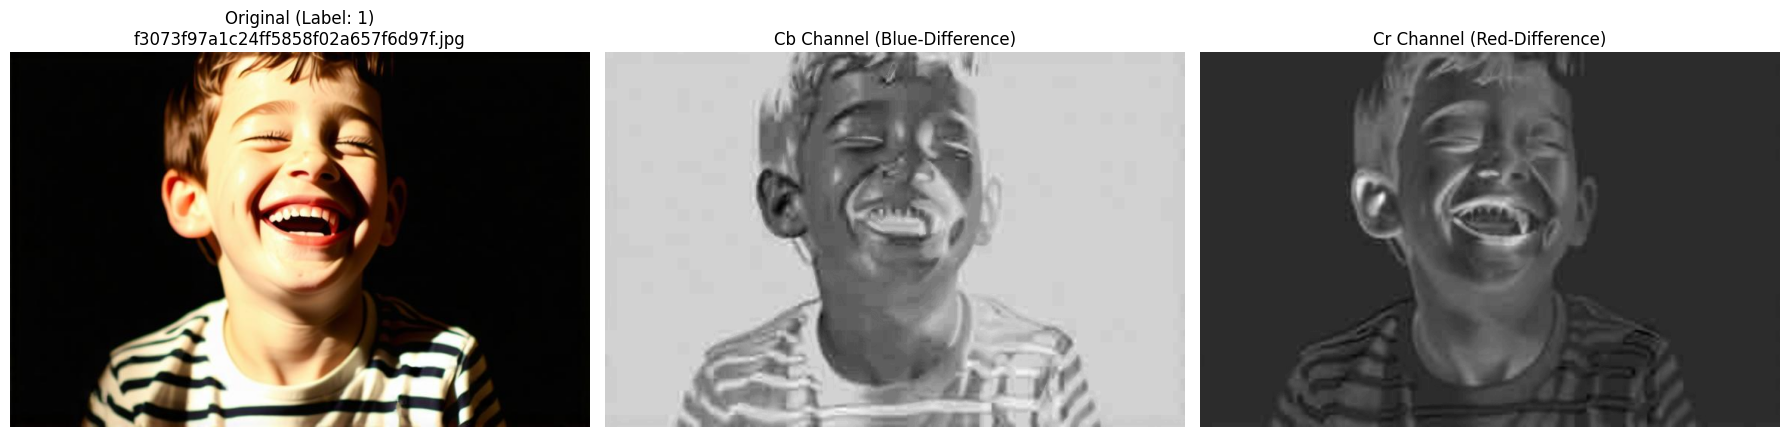

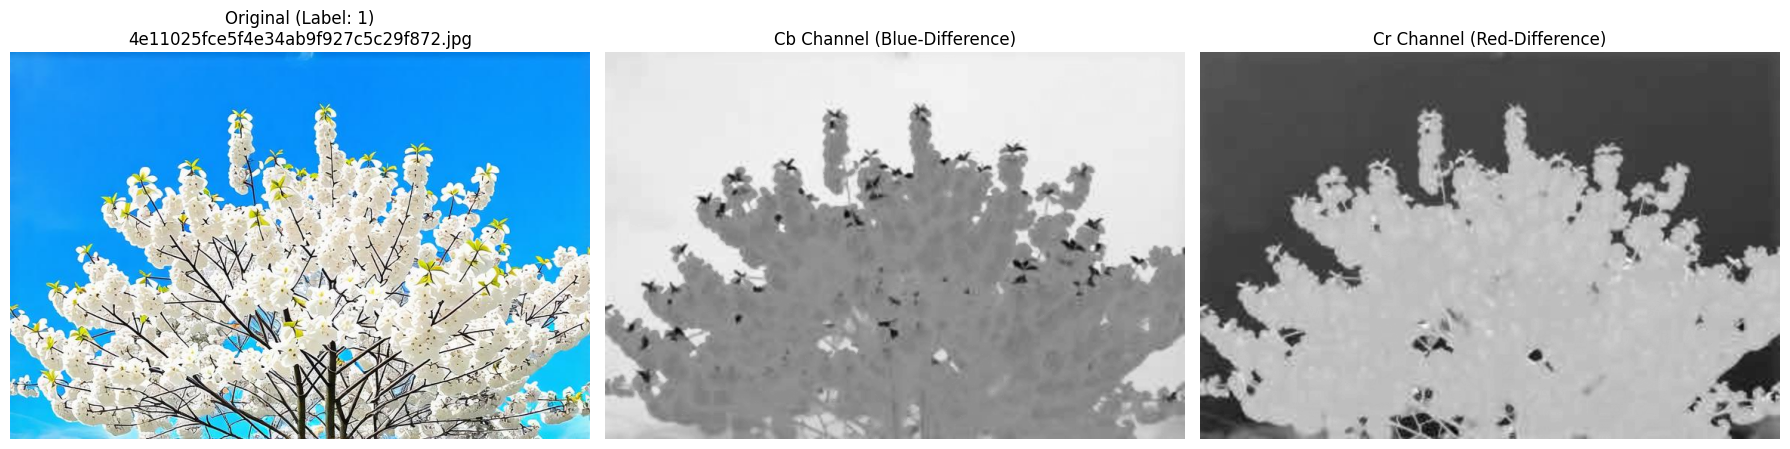

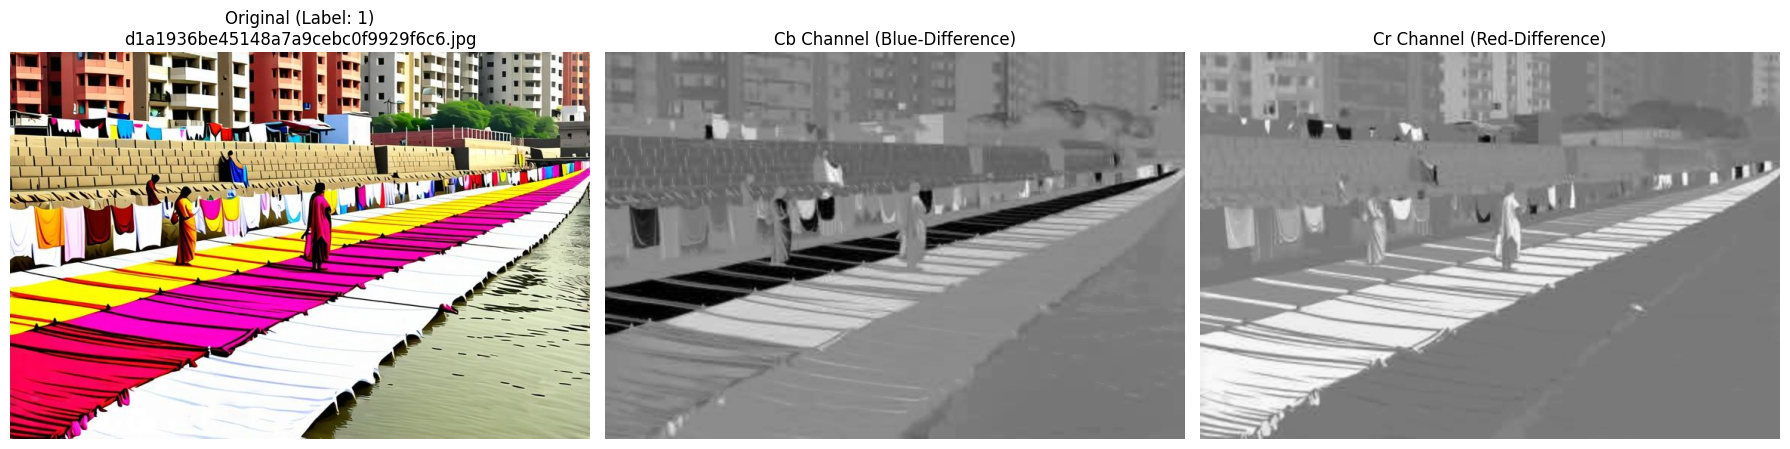

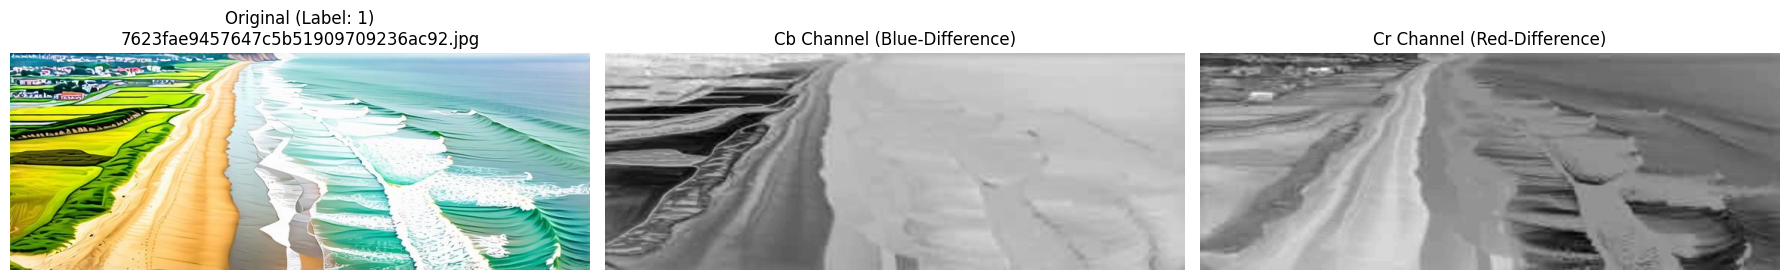

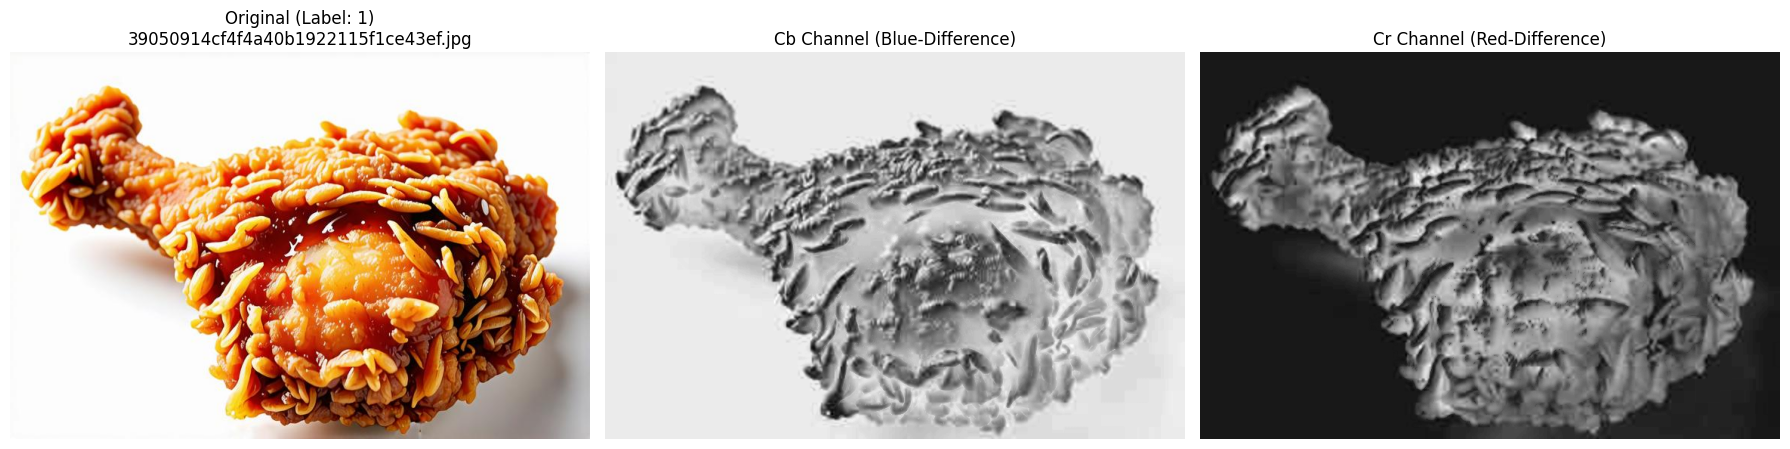

Visualizing YCbCr for Real Images (Label 0):
Found 135 images with label 0
Found 135 images with label 0


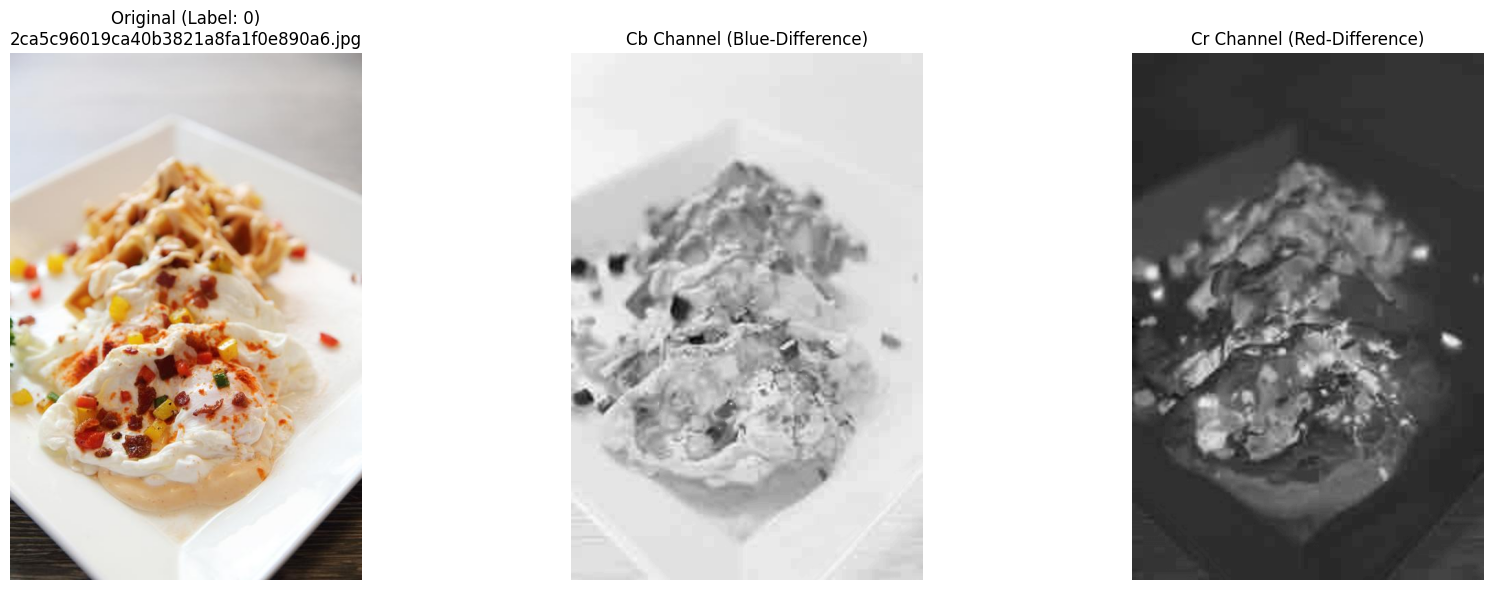

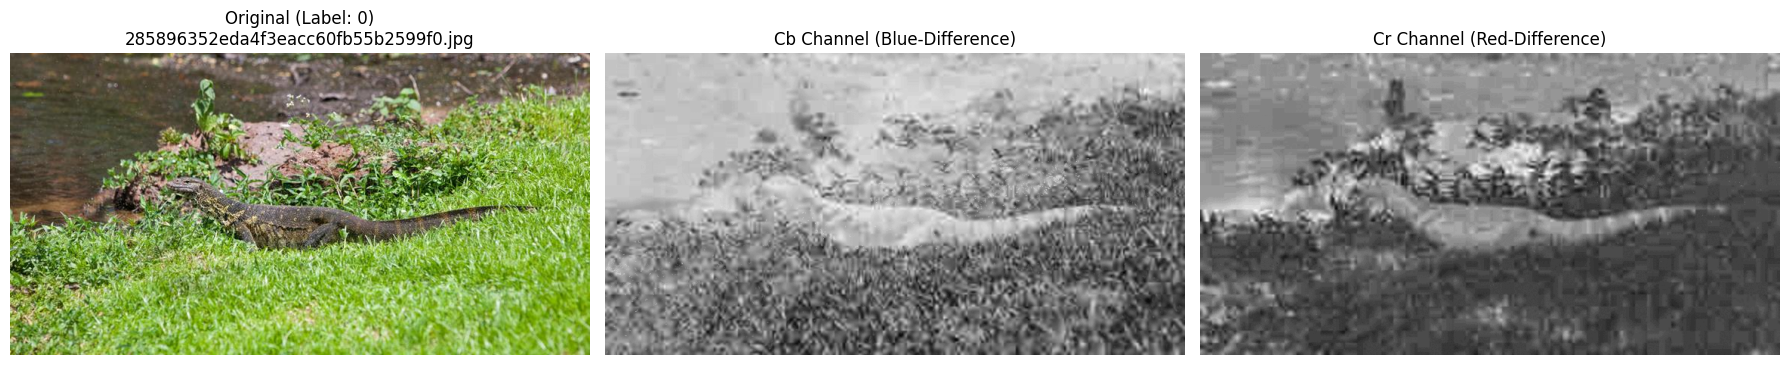

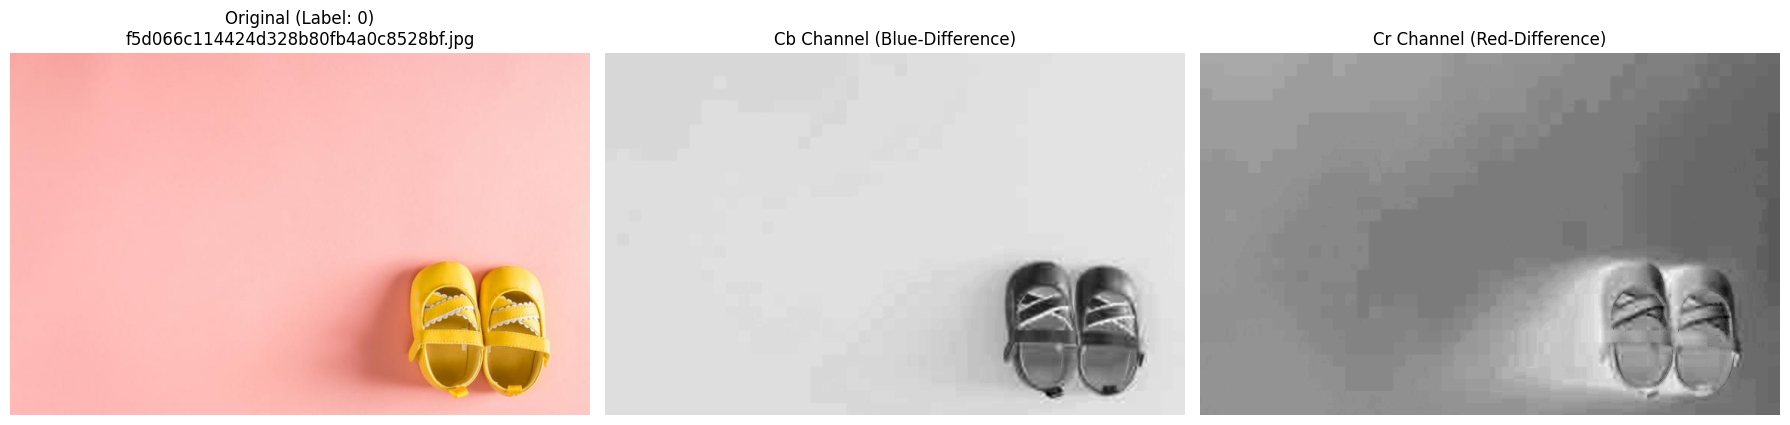

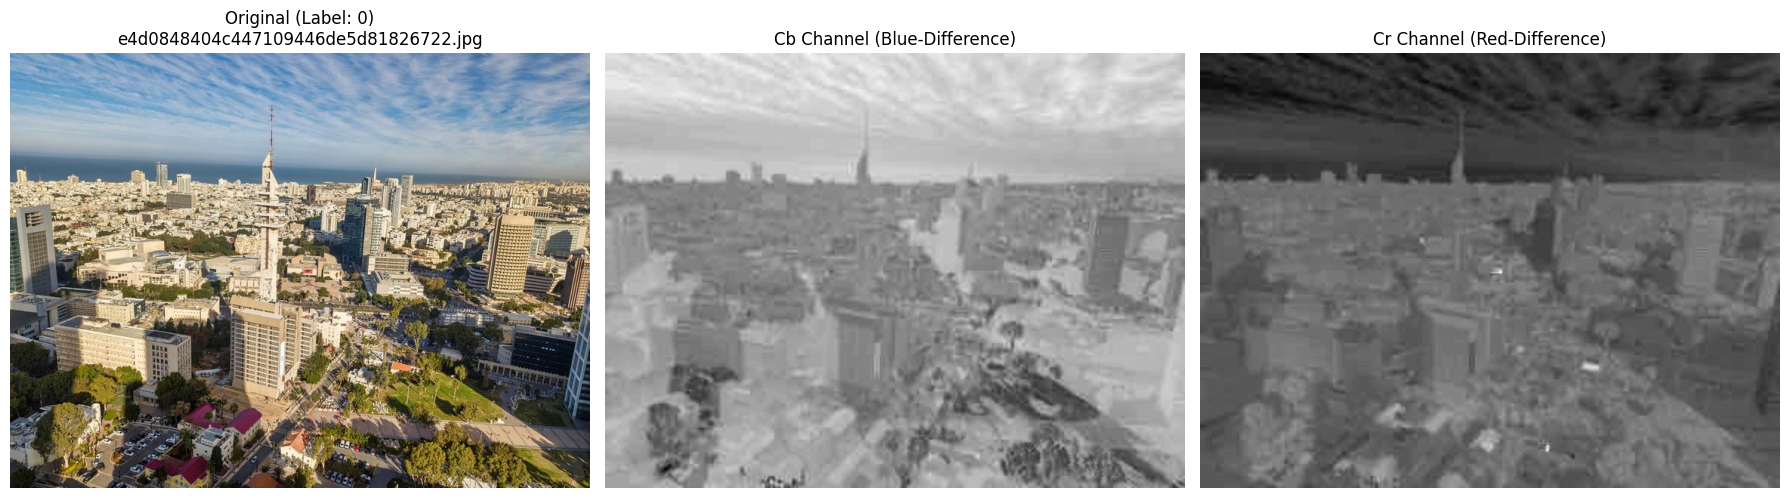

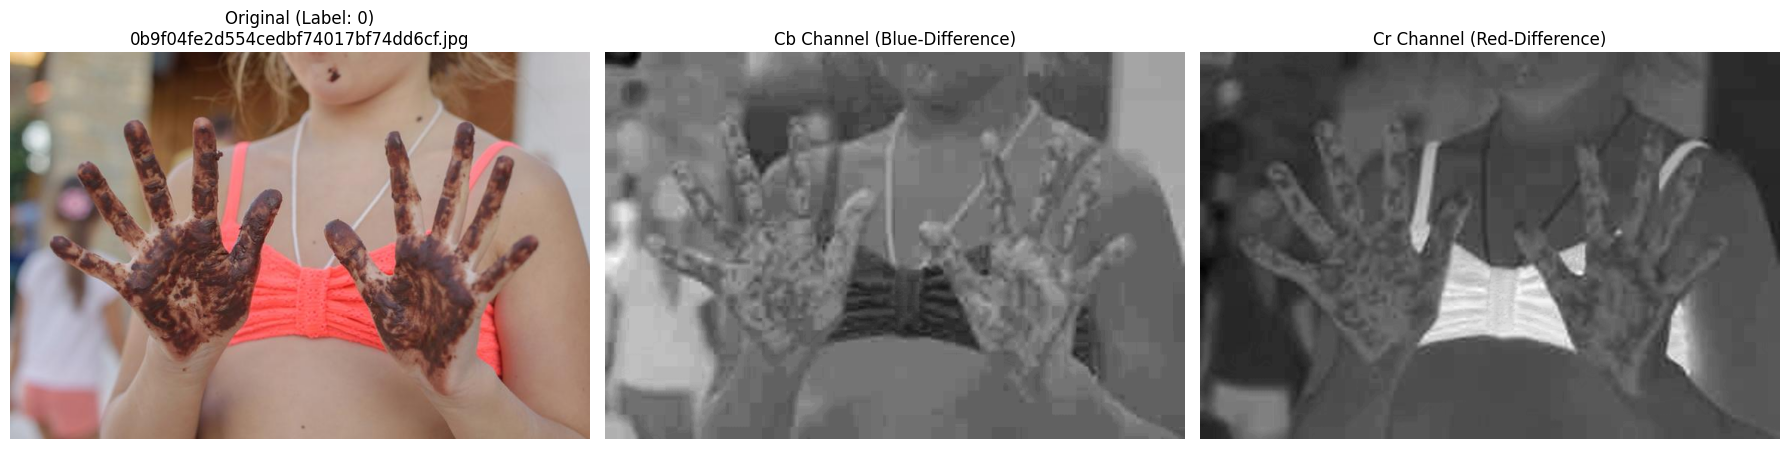

In [12]:
def visualize_ycrcb(data_dir, csv_path, num_samples=5, target_label=None):
    df = pd.read_csv(csv_path)
    
    # Create a mapping from filename (basename) to label
    label_map = {os.path.basename(path): label for path, label in zip(df['file_name'], df['label'])}
    
    image_dir = data_dir

    # List actual files in the directory
    all_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    
    # Filter by target_label if provided
    if target_label is not None:
        all_files = [f for f in all_files if label_map.get(f) == target_label]
        print(f"Found {len(all_files)} images with label {target_label}")

    if not all_files:
        print("No images found.")
        return
    
    selected_files = random.sample(all_files, min(num_samples, len(all_files)))
    
    for i, file_name in enumerate(selected_files):
        img_path = os.path.join(image_dir, file_name)
        label = label_map.get(file_name, 'Unknown')
        
        try:
            # Load and Convert to YCbCr
            img = Image.open(img_path).convert('RGB')
            img_ycbcr = img.convert('YCbCr')
            y, cb, cr = img_ycbcr.split()
            
            # Create a new figure for each image
            plt.figure(figsize=(18, 6))
            
            # 1. Original Image
            plt.subplot(1, 3, 1)
            plt.imshow(img)
            plt.title(f"Original (Label: {label})\n{file_name}")
            plt.axis('off')
            
            # 2. Cb Channel
            plt.subplot(1, 3, 2)
            plt.imshow(cb, cmap='gray')
            plt.title("Cb Channel (Blue-Difference)")
            plt.axis('off')
            
            # 3. Cr Channel
            plt.subplot(1, 3, 3)
            plt.imshow(cr, cmap='gray')
            plt.title("Cr Channel (Red-Difference)")
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Could not load {img_path}: {e}")

# Run visualization for YCbCr
print("Visualizing YCbCr for AI Generated Images (Label 1):")
visualize_ycrcb(DATA_DIR, TRAIN_CSV, num_samples=5, target_label=1)

print("Visualizing YCbCr for Real Images (Label 0):")
visualize_ycrcb(DATA_DIR, TRAIN_CSV, num_samples=5, target_label=0)